In [76]:
# Imports
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skspatial.objects import Line, Points, Plane
import yaml
import urllib.request
import os
import math

In [77]:
def open_line(file_name):
    '''
    Opens one of the text files and parses the line into a skspatial object
    '''
    
    with open(file_name) as f:
        lines = f.readlines()

    point = [float(dim) for dim in lines[0].split()[1:]]
    line = [float(dim) for dim in lines[1].split()[1:]]
    
    return Line(point, line)

In [78]:
def open_carbon_atoms(file_name):    
    
    with open(file_name) as pdb_structure:
        lines = pdb_structure.readlines()

    allCA = list()

    for line in lines:
        line = line[:22] + ' ' + line[22:] # correct .pdb stupidity        

        if len(line.split()) > 5:
            residue_num = int(line.split()[5])
            chain = line.split()[4]
        else:
            continue
        
        if 'CA' in line:
            x = float(line.split()[6])
            y = float(line.split()[7])
            z = float(line.split()[8])
            data = [x,y,z]
            allCA.append(data)   

    return np.array(allCA)

In [156]:
# This is the parameter that determines how far apart the orthogonal planes are from each other.
distance_between_planes = 10

# This is the parameter that determines the radius from the middle line that is used to check 
# for atoms to use for calculations for measurement of channel radius.
radius_to_check_for_atoms = 20

with open('../CONFIG/config_alignment.yaml', 'r') as f:
    pdb_ids = yaml.load(f, Loader=yaml.FullLoader)
lines, points_array = [], []
for channel in pdb_ids.keys():
    for ref_struct_id in pdb_ids[channel]:
        for ref_struct in list(ref_struct_id.keys()):
            for struct in list(ref_struct_id.values())[0]:
                lines.append(open_line(f"line_{ref_struct}.txt"))
                points_array.append(open_carbon_atoms(f"../DATA/ALIGNED/{channel}/{struct}.pdb"))

lines = np.array(lines)
points_array = np.array(points_array)


ipykernel_launcher:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [162]:
def channel_mouth(line, quadrants, first_plane, second_plane):
    segment_atoms= []


    for segment in quadrants:
        atoms = []
        for quadrant in segment:
            if len(quadrant) < 1: 
                continue

            for atom in quadrant:
                x = first_plane.distance_point(atom) * first_plane.side_point(atom)
                y = second_plane.distance_point(atom) * second_plane.side_point(atom)
                theta = np.arctan2(x,y)
                r = line.distance_point(atom)
                atoms.append([r,theta])

        if len(atoms) > 1:
            atoms = sorted(atoms, key = lambda x:x[1]) 
            atoms = np.array(atoms)
            segment_atoms.append(atoms)

    segment_atoms = np.array(segment_atoms)
    figure, ax = plt.subplots()
    x_value, y_value = [], []

    for atom in segment_atoms[3]:
        x_value.append(atom[0]*math.cos(atom[1]))
        y_value.append(atom[0]*math.sin(atom[1]))
    ax.plot(x_value, y_value, color = "blue")

    thetas = np.linspace(0, 2*math.pi, 12)
    inner_shape = []
    outer_shape = []
    for i in range(0, len(thetas)):
        theta_slice = []
        for atom in segment_atoms[3]:
            if thetas[i] < abs(atom[1]) < thetas[i+1]:
                theta_slice.append(atom)
        theta_slice = sorted(theta_slice, key=lambda x:x[0])
        if theta_slice:
            inner_shape.append(theta_slice[0])
            outer_shape.append(theta_slice[-1])

    inner_shape = np.array(inner_shape)
    avg_smallest_radius = 0
    avg_largest_radius = 0
    for x,y in zip(inner_shape, outer_shape):
        avg_smallest_radius += x[0]
        avg_largest_radius += y[0]
    avg_smallest_radius /= len(inner_shape)
    avg_largest_radius /= len(outer_shape)

    x_value, y_value = [], []
    for i in range(0, len(thetas)):
        x_value.append(avg_smallest_radius*math.cos(thetas[i]))
        y_value.append(avg_smallest_radius*math.sin(thetas[i]))
    ax.plot(x_value, y_value, color = "red")

    x_value, y_value = [], []
    for i in range(0, len(thetas)):
        x_value.append(avg_largest_radius*math.cos(thetas[i]))
        y_value.append(avg_largest_radius*math.sin(thetas[i]))
    ax.plot(x_value, y_value, color = "red")




In [150]:
def create_segments(line, points, first_plane, second_plane):
    # Separate the line/channel into arbitrary size length. Create orthogonal planes to the two perpendicular planes.

    plane_points = np.array([line.point + line.vector * i for i in range(-100, 100, distance_between_planes)])
    orthogonal_planes = np.array([Plane(plane_points[i], line.vector) for i in range(plane_points.shape[0])])

    # fig = plt.figure(figsize=(8,8))
    # ax = Axes3D(fig)

    # line.plot_3d(ax, -100, 100, linewidth = 7, c = 'g')
    # ax.scatter(points[:,0], points[:,1], points[:,2], c = 'b', marker = 'o')

    # for plane in orthogonal_planes:
    #     plane.plot_3d(ax, lims_x = (-40, 40), lims_y = (-40, 40), color = 'y', alpha = 0.5)

    # ax.set_label(['x','y','z'])
    # plt.show()

    # Determine what quadrant carbon atoms are in

    quadrants = np.ndarray((orthogonal_planes.shape[0] - 1, 4), object)

    for i in range(orthogonal_planes.shape[0] - 1):
        quadrant_1, quadrant_2, quadrant_3, quadrant_4 = [], [], [], []
    
        for atom in points:
            if orthogonal_planes[i].side_point(atom) > 0 and orthogonal_planes[i + 1].side_point(atom) < 0:
                if line.distance_point(atom) < radius_to_check_for_atoms:
                    if first_plane.side_point(atom) < 0 and second_plane.side_point(atom) > 0:
                        quadrant_1.append(atom)                    
                    elif first_plane.side_point(atom) > 0 and second_plane.side_point(atom) > 0:
                        quadrant_2.append(atom)                    
                    elif first_plane.side_point(atom) > 0 and second_plane.side_point(atom) < 0:
                        quadrant_3.append(atom)                    
                    elif first_plane.side_point(atom) < 0 and second_plane.side_point(atom) < 0:
                        quadrant_4.append(atom)
    
        quadrants[i][0] = quadrant_1
        quadrants[i][1] = quadrant_2
        quadrants[i][2] = quadrant_3
        quadrants[i][3] = quadrant_4

    # print("Number of points per quadrant:")
    # print("N.B. shape = (number of planes x number of quadrants)")
    # for plane in quadrants:
    #     print([len(plane[i]) for i in range(4)])
    # channel_mouth(line, quadrants, first_plane, second_plane)

In [153]:
def do_everything(line, points):
    origin = [0, 0, 0]
    origin_projection = line.project_point(origin)
    perpendicular_line = Line(origin_projection, origin - origin_projection)
    normal_vector = perpendicular_line.vector.cross(line.vector)
    first_plane = Plane(origin_projection, normal_vector)
    second_plane = Plane(origin_projection, line.vector.cross(normal_vector))
 

    # line.plot_3d(ax, -100, 100, linewidth = 7, c = 'g')
    # first_plane.plot_3d(ax, lims_x = (-20, 20), lims_y = (-20, 20), alpha = 0.5)
    # second_plane.plot_3d(ax, lims_x = (-20, 20), lims_y = (-20, 20), alpha = 0.5)
    # ax.scatter(points[:,0], points[:,1], points[:,2], c = 'b', marker = 'o')
    # ax.scatter(line.point[0], line.point[1], line.point[2], c = 'y', marker = 'o')
    # ax.set_label(['x','y','z'])
    # plt.show()
    create_segments(line, points, first_plane, second_plane)

Number of points per quadrant:
N.B. shape = (number of planes x number of quadrants)
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[1, 0, 0, 0]
[7, 3, 5, 0]
[18, 8, 13, 11]
[19, 18, 15, 14]
[19, 20, 13, 19]
[17, 14, 13, 16]
[23, 18, 23, 20]
[7, 13, 4, 9]
[0, 2, 0, 8]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]


ipykernel_launcher:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


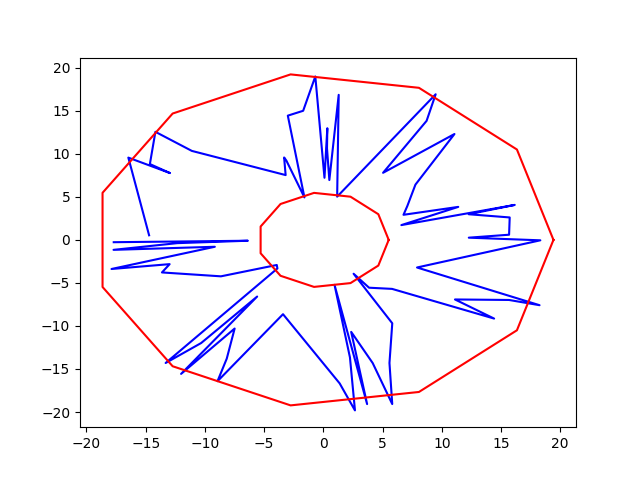

In [163]:
# file_name = "7EJ1"
# channel_type = "KCN"

# # This is the parameter that determines how far apart the orthogonal planes are from each other.
# distance_between_planes = 10

# # This is the parameter that determines the radius from the middle line that is used to check 
# # for atoms to use for calculations for measurement of channel radius.
# radius_to_check_for_atoms = 20
# # Open line and carbon atoms for 6V01

# Show Mark problem with 6V01
# line = open_line(f"line_{file_name}.txt")
# points = open_carbon_atoms(f"../DATA/ALIGNED/{channel_type}/{file_name}.pdb")

for line, points in zip(lines, points_array):
    do_everything(line, points)
    break
# Generate planes

# origin = [0, 0, 0]
# origin_projection = line.project_point(origin)
# perpendicular_line = Line(origin_projection, origin - origin_projection)
# normal_vector = perpendicular_line.vector.cross(line.vector)
# first_plane = Plane(origin_projection, normal_vector)
# second_plane = Plane(origin_projection, line.vector.cross(normal_vector))

